# 第2章 特徴量抽出

コンピュータで音を扱う場合は波として扱う。しかし、波はそのままだと情報量が多い上にそのほとんどはノイズ（意味を持たないデータ）である。  
そのため、音声解析を行う場合は、元の波から意味のある値を抽出することが重要である。そしてその値を**特徴量**と呼ぶ。

本章では、音声における様々な特徴量とその抽出方法を学ぶ。

In [37]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 4)
from IPython.display import Audio, display


---

## フーリエ変換

波に含まれている周波数を解析する。音声に限らず、波を扱う場面で広く活用されている。

<br>

全ての波は、周波数の異なるsin波の和で表現できることが知られている。ある波をsin波の和で表現することを**フーリエ変換**と呼ぶ。  
フーリエ変換を行うことで、元の波に、「どの周波数がどれくらい含まれているか」が分かる。

波において周波数は大きな意味を持つ場合が多い。例えば可視光だったら周波数は色を表し、脳波だったら精神状態を表すと言われている。  
音においても同じで、周波数は音の高さを表し、そこから音色、ノイズ、声色などを推測することもできる。

つまり周波数を特定するためのフーリエ変換は、波を解析する場面で非常に重要な役割を果たす。

<br>

数学的な理論はここでは省略するが、個人的にとても分かり易かった説明動画を載せておく。
- [【視覚的に理解する】フーリエ変換 - YouTube](https://youtu.be/fGos3wrKeHY)

#### 高速フーリエ変換 （*FFT - Fast Fourier Transform*）

離散フーリエ変換（コンピュータで扱う様な離散的な波を対象としたフーリエ変換）を高速で行うアルゴリズム。  
一般的にコンピュータでフーリエ変換を行う場合はFFTを使用する。

<br>

では実際にフーリエ変換を行ってみよう。  
とりあえず適当な波を用意する。


In [15]:
sr = 44100

def sin_wave(freq=440, sr=sr, amp=1, sec=1):
    t = np.arange(0, sec, 1/sr)
    return amp * np.sin(2*np.pi*freq*t)

def sin_wave_from_midi(num, sr=sr, amp=1, sec=1):
    freq = 2**((num-69)/12)*440
    print('frequncy:', freq)
    return sin_wave(freq, sr, amp, sec)

frequncy: 261.6255653005986
frequncy: 329.6275569128699
frequncy: 391.99543598174927


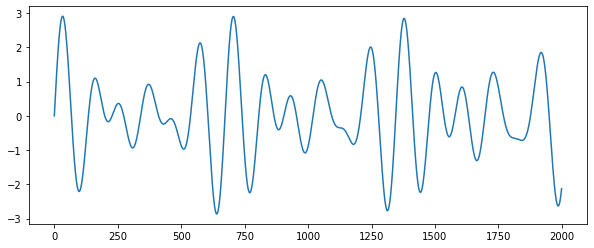

In [16]:
y1 = sin_wave_from_midi(60)
y2 = sin_wave_from_midi(64)
y3 = sin_wave_from_midi(67)
y = y1 + y2 + y3
plt.plot(y[:2000])
Audio(y, rate=sr)

3つの周波数（260, 330, 490）の波を足して1つの波を作った。  
この波をフーリエ変換してみる。

<br>

`scypy.fft`もしくは`numpy.fft`が簡単。使い方はどちらも一緒  

[Discrete Fourier Transform (numpy.fft) — NumPy v1.22 Manual](https://numpy.org/doc/stable/reference/routines.fft.html)  
[Discrete Fourier transforms (scipy.fft) — SciPy v1.8.0 Manual](https://docs.scipy.org/doc/scipy/reference/fft.html)

In [20]:
fft = np.fft.fft(y)
fft

array([82.55895813+0.j        , 82.55995858+0.12049793j,
       82.56296009+0.24100486j, ..., 82.56796312-0.36152977j,
       82.56296009-0.24100486j, 82.55995858-0.12049793j])

フーリエ変換を行うと、同じ長さの複素数の配列が得られる。

これらの複素数の絶対値が、対応する周波数の強さを表している。  
対応する周波数は`numpy.fft.fftfreq`で作れる。

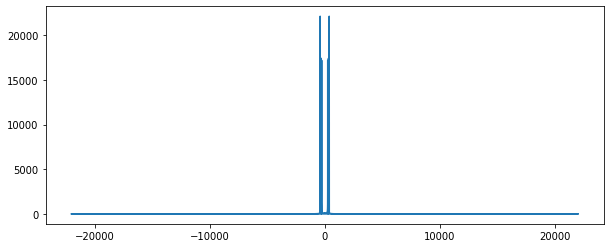

In [25]:
fftfreq = np.fft.fftfreq(len(y), d=1/sr) # 配列の長さと周期を入力
plt.plot(fftfreq, np.abs(fft));

描画するとこうなる。横軸が周波数、縦軸が強さ。  
0を中心に対象となっているので、半分は無視してよい。あと負の周波数についてはここでは触れない。とりあえず正の部分だけ取ってくる。

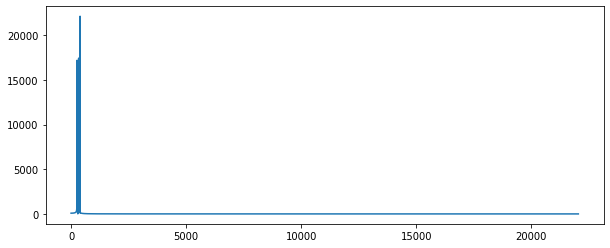

In [31]:
idx = fftfreq >= 0
plt.plot(fftfreq[idx], np.abs(fft)[idx]);

正の部分だけ取ってきて、0~1000までを拡大した。

> 3つの周波数（260, 330, 490）の波を足して1つの波を作った。
これを確かめたいので、拡大する

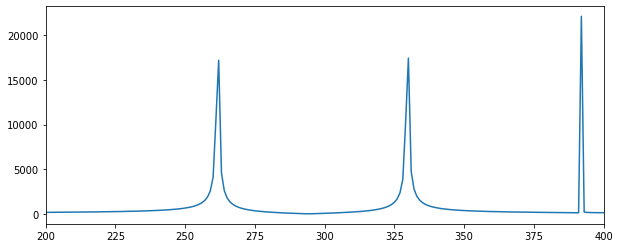

In [32]:
plt.plot(fftfreq[idx], np.abs(fft)[idx])
plt.xlim(200, 400);

しっかりと抽出できていることが分かる。

ちなみにnumpyよりscipyの方若干早い

In [38]:
import scipy.fft

In [33]:
%%timeit
np.fft.fft(y)

356 µs ± 4.31 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [39]:
%%timeit
scipy.fft.fft(y)

303 µs ± 4.62 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### 逆フーリエ変換（*IFFT - Inverse Fast Fourier Transform*）

フーリエ変換の逆をする。周波数の情報から時間波形を生成する  
[numpy.fft.ifft — NumPy v1.22 Manual](https://numpy.org/doc/stable/reference/generated/numpy.fft.ifft.html)

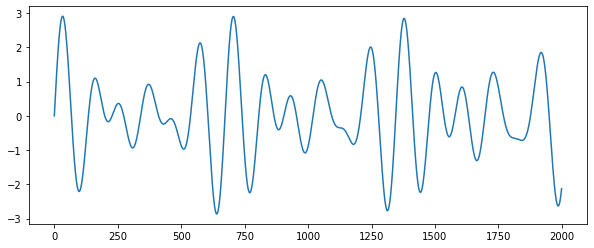

In [48]:
y = np.fft.ifft(fft).real # 絶対値ではなく実部をとる
plt.plot(y[:2000])
display(Audio(y, rate=sr))

復元できた。

### 短時間フーリエ変換（*STFT - Short Time Fourier Transform*）

普通のフーリエ変換では、与えた波全体に対する周波数の強さを求めた。  
一方で短時間フーリエ変換では、範囲をある一部分に限定してフーリエ変換を行う。その範囲を少しずつずらしながらフーリエ変換を行うことで、周波数の推移が分かる。またこの範囲を窓と呼ぶ。

<br>

イメージ

![img](https://camo.qiitausercontent.com/16fc6afba77d6e9142ce3772a6f4de0b0aedee70/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e61702d6e6f727468656173742d312e616d617a6f6e6177732e636f6d2f302f3138363333382f33333335663631362d303731392d623034342d313462342d6435316637346566623362342e706e67)

**参考**  
[Pythonの音声処理ライブラリ【LibROSA】で音声読み込み⇒スペクトログラム変換・表示⇒位相推定して音声復元 - Qiita](https://qiita.com/lilacs/items/a331a8933ec135f63ab1)

<br>

では実際にやってみよう。

周波数が3秒間かけて4000hzまで上がる音声を用意した。

In [49]:
import scipy.signal

In [50]:
sec = 3
sr = 22050
t = np.linspace(0, sec, sr*sec)
y = scipy.signal.chirp(t, 0, sec, 4000)
Audio(y, rate=sr)

これに対してSTFTを行う。`librosa.stft`を使うと簡単。  
[librosa.stft — librosa 0.9.2 documentation](https://librosa.org/doc/latest/generated/librosa.stft.html#librosa.stft)

In [51]:
import librosa

In [54]:
stft = librosa.stft(y)
print("shape:", stft.shape)
stft

shape: (1025, 130)


array([[ 4.75599811e+02+0.00000000e+00j,  2.08824744e+02+0.00000000e+00j,
        -2.47301049e+01+0.00000000e+00j, ...,
         3.27778782e-06+0.00000000e+00j, -1.41534506e-05+0.00000000e+00j,
        -2.84956469e-05+0.00000000e+00j],
       [-5.15138510e+02-7.10542736e-15j,  3.17936373e+01-2.65747723e+02j,
         6.37205563e+00+4.03345335e+01j, ...,
         3.27817492e-06+1.99942257e-08j, -8.57712213e-06-7.64729970e-06j,
         1.55128631e-05-6.86156287e-06j],
       [ 4.01723670e+02+6.77236045e-15j, -2.93077685e+02+1.37598669e+02j,
         8.59145658e+01-4.43083870e+00j, ...,
         3.27840188e-06+3.98838346e-08j,  4.02221363e-07-4.67308238e-06j,
        -2.43077927e-05+1.31194349e-05j],
       ...,
       [ 3.95368716e-09-5.55111512e-16j,  9.75816761e-09-1.31464617e-09j,
        -1.03842339e-08+1.79031323e-09j, ...,
        -5.40832850e-07-3.32972893e-09j,  2.05557016e-06+7.87483802e-07j,
        -2.16505323e-06-2.21064948e-06j],
       [ 3.95357347e-09-8.88178420e-16j,  9.

（1 + 窓の長さ/2, 信号長/ホップ長）の配列が得られる。

<br>


結果は **\*スペクトログラム** として描画すると分かり易い。

[スペクトログラム](http://adlib.rsch.tuis.ac.jp/~akira/zemi/ocampus/html/specana.html)  
各時間の各周波数の強さを色で表すことで **周波数・時間・強さ** の3次元の情報を表す。  

<br>

スペクトログラムの描画は、`librosa.display.specshow()`が便利  
[librosa.display.specshow — librosa 0.6.0 documentation](http://man.hubwiz.com/docset/LibROSA.docset/Contents/Resources/Documents/generated/librosa.display.specshow.html)

In [57]:
# librosaとは別でimportする必要がある
import librosa.display

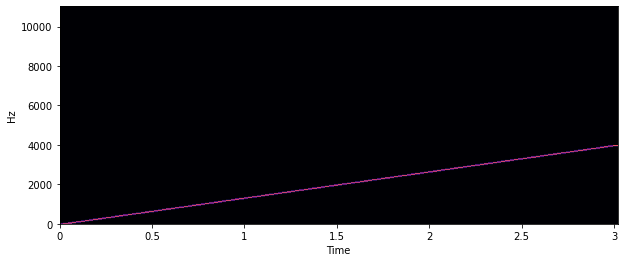

In [58]:
librosa.display.specshow(np.abs(stft), sr=sr, x_axis='time', y_axis='hz');

> 周波数が3秒間かけて4000hzまで上がる音声

これが表されているのが分かる


---

## メル周波数ケプストラム係数 (MFCC)

人間の聴覚特徴を考慮した周波数情報を取得する

<br>

**参考**
- [MFCC（メル周波数ケプストラム係数）入門 - Qiita](https://qiita.com/tmtakashi_dist/items/eecb705ea48260db0b62#%E3%83%A1%E3%83%AB%E5%B0%BA%E5%BA%A6)
- [音響特徴量「メルスペクトル」と「MFCC（メル周波数ケプストラム係数）」の解説と実例紹介 – FAST-D技術ブログ](https://fast-d.hmcom.co.jp/blog/melspectrum-mfcc/)
- [【超初心者向け】pythonで音声認識⑦「ケプストラムを抽出してみよう」Beginaid](https://tips-memo.com/python-cepstrum)

### メル周波数

<u>人間の聴覚特徴</u>を考慮して周波数を表す指標  
→ 人間の耳は、**低い音に敏感**(実際より高く聞こえる)で**高い音に鈍感**(実際より低く聞こえる)という特徴がある

<br>

元の周波数を$f$とすると、メル周波数 $mel$ は以下の式で求められる

$$
mel = 2595 \, log_{10} \, (1 + \frac{f}{700})
$$

<br>

周波数とメル周波数の関係をグラフにするとこうなる

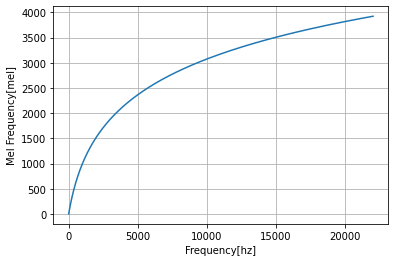

In [59]:
freq2mel = lambda f: 2595 * np.log10(1 + (f/700))
f = np.arange(22050)
plt.figure(figsize=(6, 4))
plt.plot(f, freq2mel(f))
plt.xlabel('Frequency[hz]')
plt.ylabel('Mel Frequency[mel]')
plt.grid()

<br>

##### ケプストラム

元の波形をフーリエ変換して得た周波数情報の大まかな特徴を知る  
音声認識とかに使えるらしい

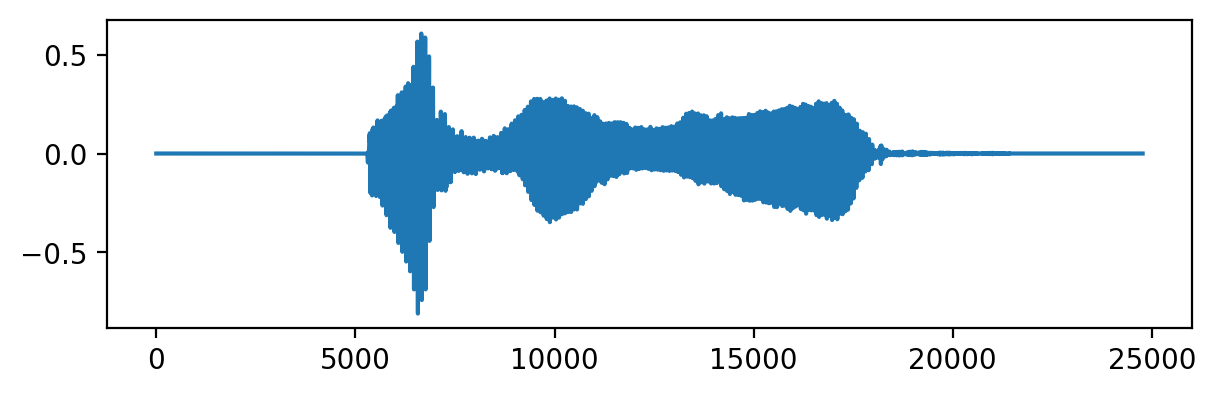

In [ ]:
voice, sr = librosa.load('sample-sounds/ohayo.wav')
plt.plot(voice)
Audio(voice, rate=sr)

これをとりあえずフーリエ変換する

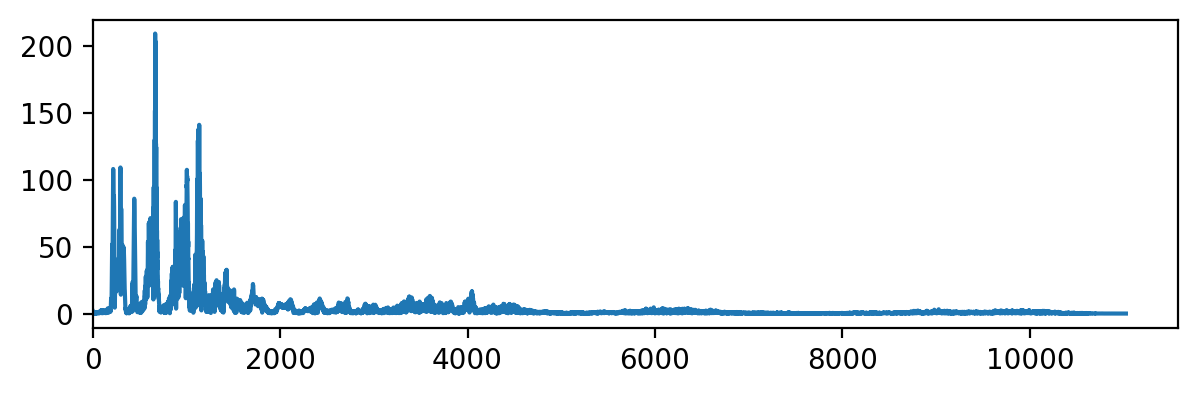

In [ ]:
n = len(voice)
fft = np.fft.fft(voice)
scale = np.fft.fftfreq(n, d=1/sr)
plt.plot(scale[:n // 2], np.abs(fft)[:n // 2])
plt.xlim(0,);

対数をとって変化を分かりやすくする

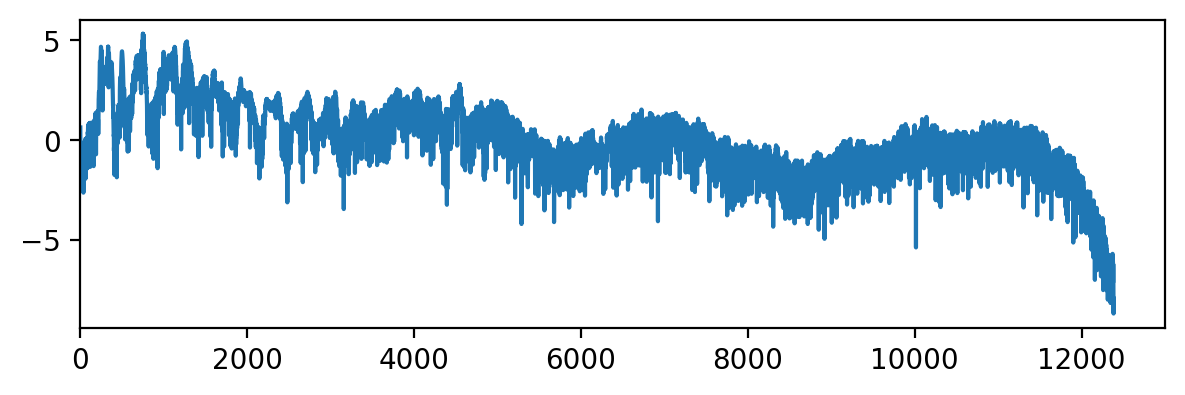

In [ ]:
spec = np.log(np.abs(fft))[:n // 2]
plt.plot(spec)
plt.xlim(0,);

**\*面倒くさいので周波数軸なし (インデックス=周波数という設定)**

<br>

これの大まかな形をとりたい

→ これをフーリエ変換して、低周波数部分だけを使って逆フーリエ変換したら、いい感じにノイズが減りそう

<br>

ということでさらにフーリエ変換

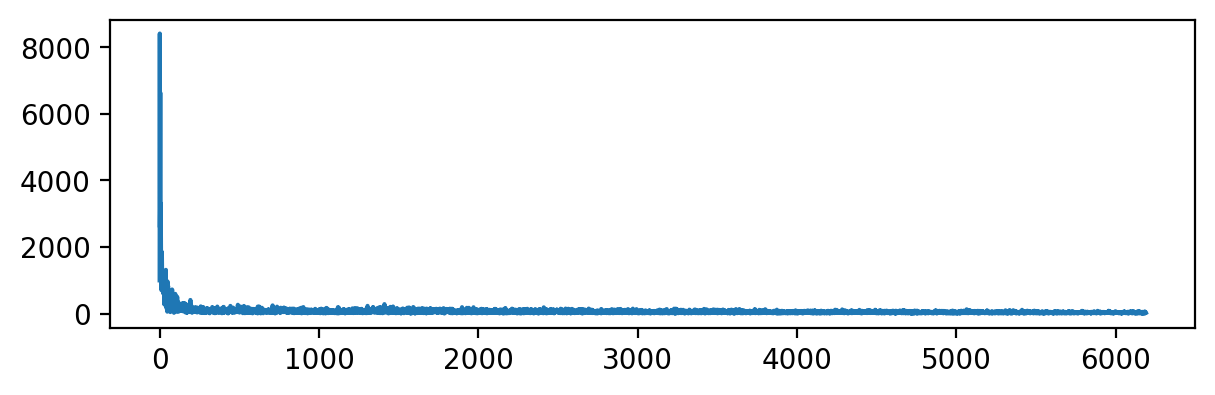

In [ ]:
fft2 = np.fft.fft(spec)
plt.plot(np.abs(fft2[:len(fft2) // 2]));

高周波数部分を除去して逆フーリエ変換

/home/komiya/private/study/sound-processing/.venv/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


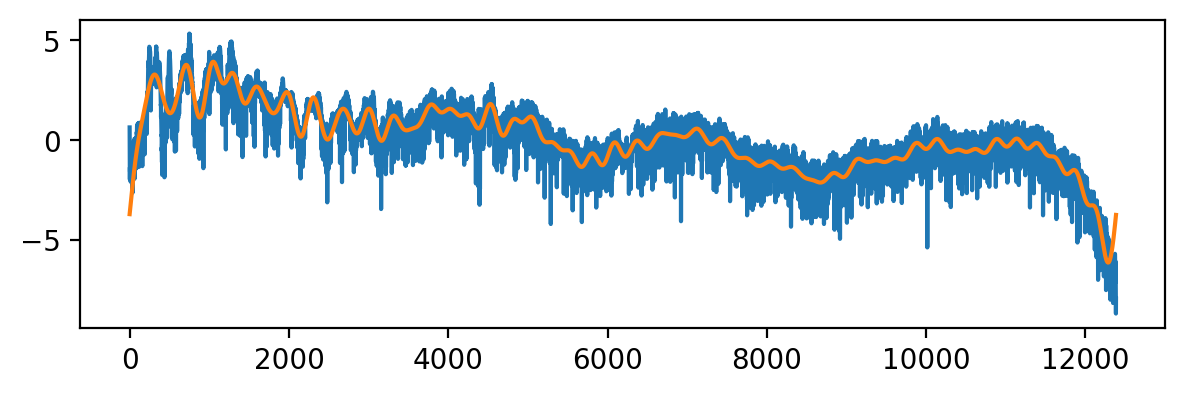

In [ ]:
lim = 50
fft2[lim:len(fft2) - lim] = 0
cepstrum = np.fft.ifft(fft2)
plt.plot(spec)
plt.plot(cepstrum);

このオレンジの線を**ケプストラム**という

<br>

##### メル周波数ケプストラム係数

人間の聴覚特徴を考慮したケプストラムを低次元に圧縮したもの

<br>

さっきと同じこのスペクトルからメル周波数ケプストラムをとる

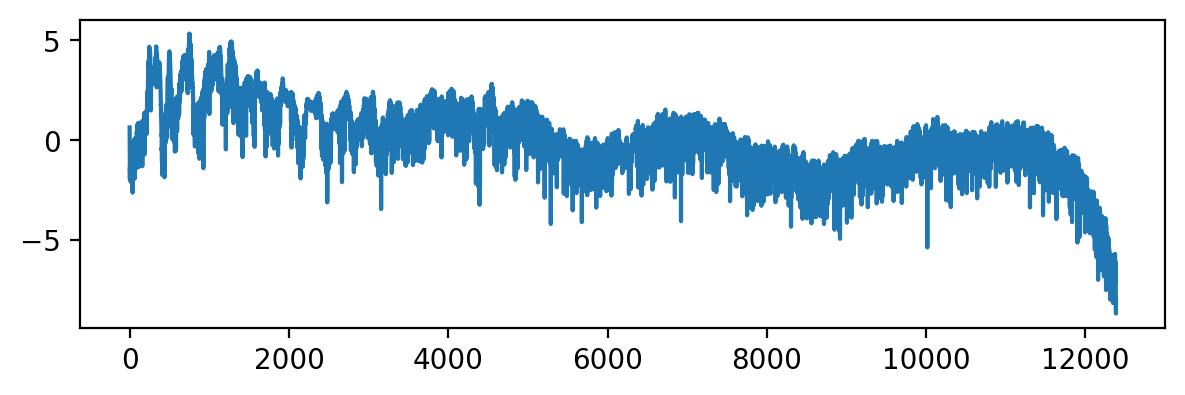

In [ ]:
plt.plot(spec);

先程はこれをフーリエ変換し、低周波数部分のみを使って逆フーリエ変換するという手法で大まかな構造をとったが、**移動平均法**を用いても同じことができそう

<br>

ということでやってみる。この時にサンプル数を定めて等間隔に平均をとる

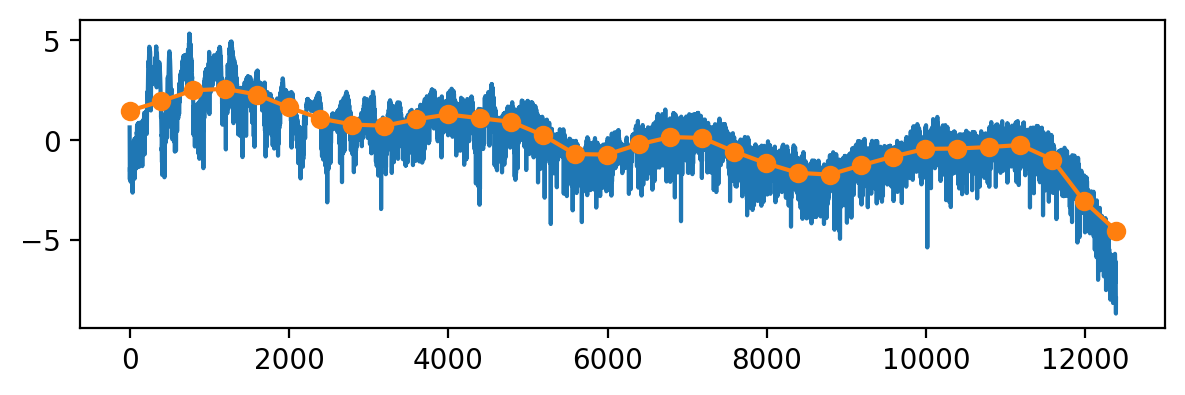

In [ ]:
N = len(spec)
n = 32 # サンプル数
means = []
idx = np.linspace(0, N - 1, n, dtype=int)
for i in range(n):
    start = idx[max(0, i - 1)]
    end = idx[min(i + 1, n - 1)]
    means.append(spec[start:end].mean())
plt.plot(spec)
plt.plot(idx, means, 'o-');

これを、**メル周波数**が等間隔になるようにとるのが**メル周波数ケプストラム**

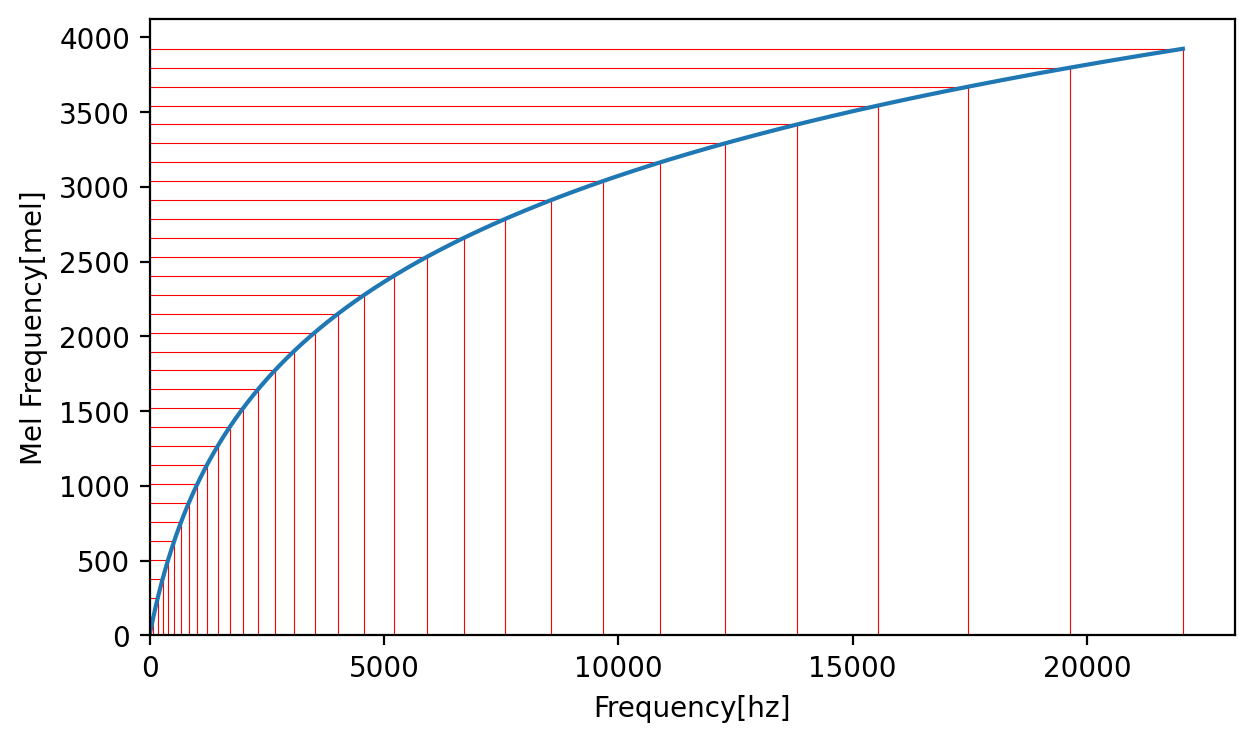

In [ ]:
mel2freq = lambda m: 700 * (10 ** (m / 2595) - 1.0)
f = np.arange(22050)
plt.figure(figsize=(7, 4))
mel = freq2mel(f)
plt.plot(f, mel)
y = np.linspace(0, mel.max(), n)
for m in y:
    plt.hlines(m, 0, mel2freq(m), color='red', lw=0.4)
    plt.vlines(mel2freq(m), 0, m, color='red', lw=0.4)
plt.xlabel('Frequency[hz]')
plt.ylabel('Mel Frequency[mel]')
plt.xlim(0,)
plt.ylim(0,);

メル周波数は、

> 人間の耳は、**低い音に敏感**(実際より高く聞こえる)で**高い音に鈍感**(実際より低く聞こえる)という特徴がある

という特徴を考慮した指標なので、低周波数帯では細かく、高周波数帯では間隔が広くなっている

この横軸の間隔に合わせて平均をとるとこうなる

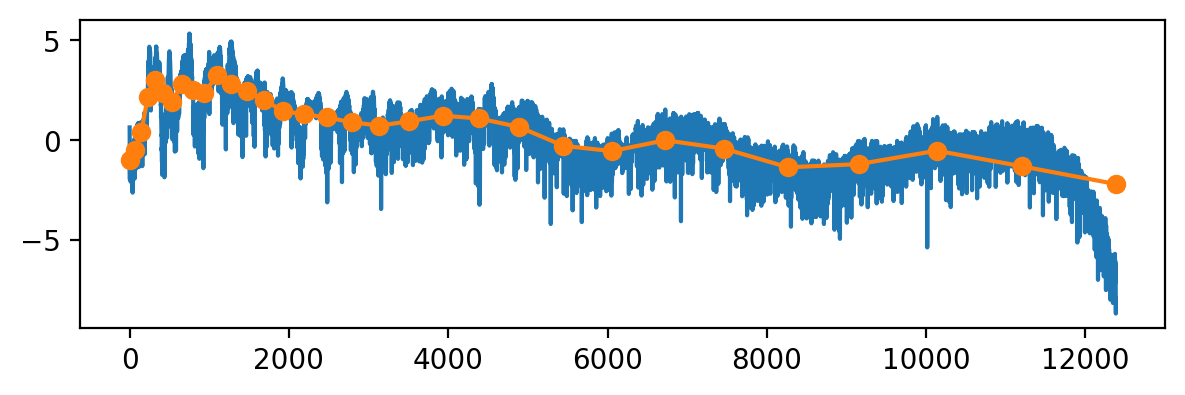

In [ ]:
means = []
y = np.linspace(0, freq2mel(len(spec)), n)
x = mel2freq(y)
for i in range(n):
    start = int(x[max(0, i - 1)])
    end = int(x[min(i + 1, n - 1)])
    means.append(spec[start:end].mean())
plt.plot(spec)
plt.plot(x, means, 'o-');

このようなものを**メル周波数ケプストラム**という

\*ちなみに実際は平均値ではなく**メルフィルタバンク**というものの内積をとっている

<br>

そしてこれを**離散コサイン変換**した結果が**メル周波数ケプストラム係数(MFCC)** である。  
情報量をさらに圧縮することが出来る

**\*離散コサイン変換 (DCT)**  
離散フーリエ変換の亜種みたいなやつ

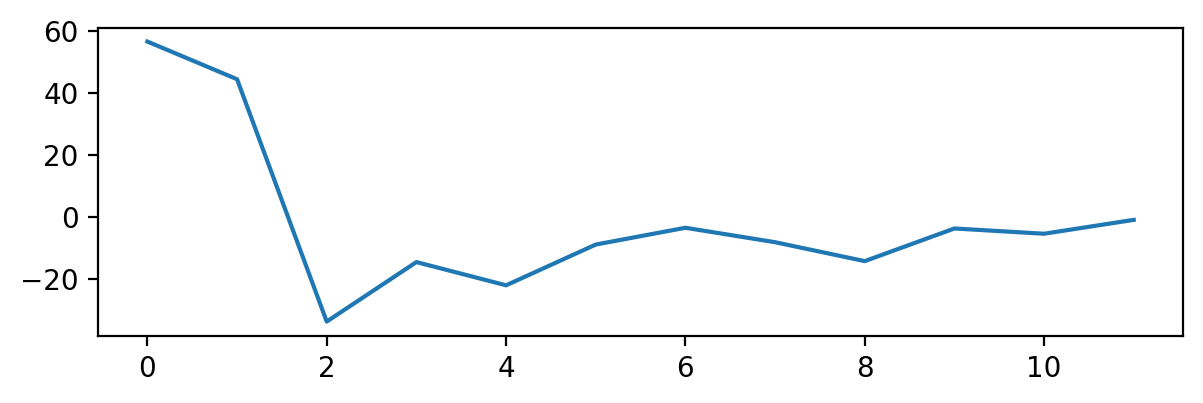

In [ ]:
dct = scipy.fftpack.dct(means)
mfcc = dct[:12] # 12次元まで取ることが多いらしい
plt.plot(mfcc);

<br>

librosaを使うと各フレームのMFCCを取得できる (STFTのように範囲を少しずつずらしていく感じ)

In [ ]:
mfcc = librosa.feature.mfcc(shiningstar, n_mfcc=12)
mfcc.shape

(12, 528)

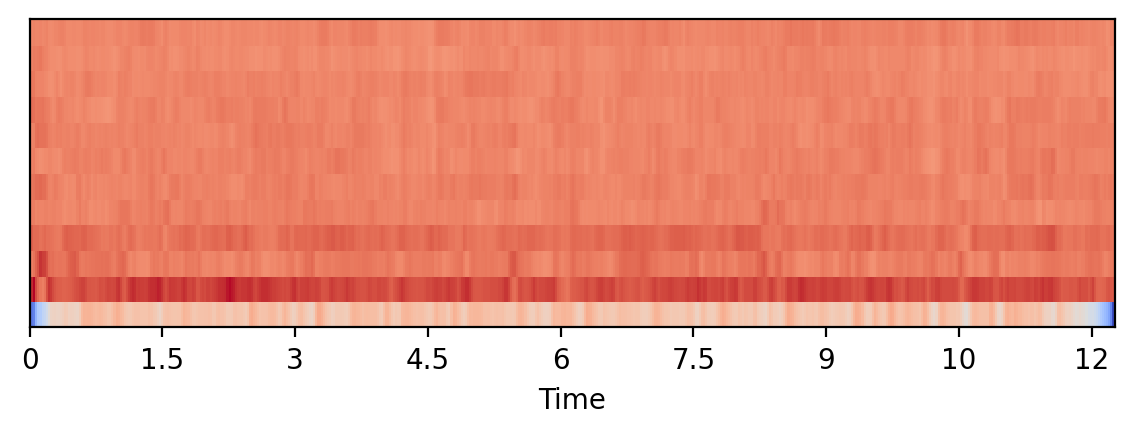

In [ ]:
librosa.display.specshow(mfcc, sr=sr, x_axis='time');

<br>

#### ゼロクロス率 (ZCR)

信号が0を跨いだ割合。振幅の正負が入れ替わった割合。

**参考**  
[【超初心者向け】pythonで音声認識⑧「ゼロ交差数で無声区間の判定をしよう」Beginaid](https://tips-memo.com/python-zero-crossings)

In [ ]:
def zcr(y):
    return np.mean((y[:-1] * y[1:]) < 0)

In [ ]:
zcr(shiningstar)

0.09604948508562164

0.096だった

librosaでもできる。各位置で入れ替わったかどうかがbool値で返される  
[librosa.zero_crossings —librosa0.9.1ドキュメント](http://librosa.org/doc/main/generated/librosa.zero_crossings.html#librosa.zero_crossings)

In [ ]:
librosa.zero_crossings(shiningstar)

array([ True, False, False, ..., False, False, False])

`librosa.feature.zero_crossing_rate()`を使えば各フレームのゼロクロス率がとれる  
[librosa.feature.zero_crossing_rate —librosa0.9.1ドキュメント](http://librosa.org/doc/main/generated/librosa.feature.zero_crossing_rate.html)

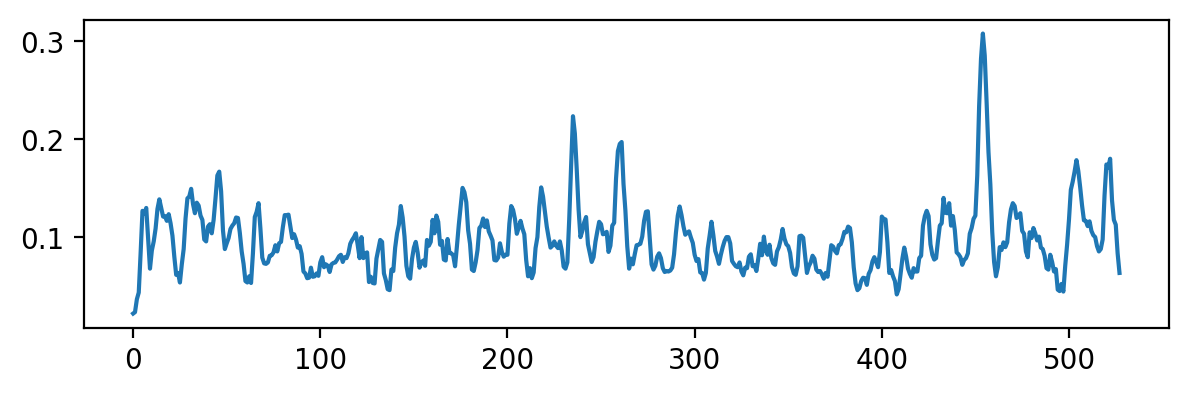

In [ ]:
ZCR, = librosa.feature.zero_crossing_rate(shiningstar)
plt.plot(ZCR);

ゼロクロス率が高いということは、ノイズが多く入っているということである。

ホワイトノイズのゼロクロス率はこんな感じ

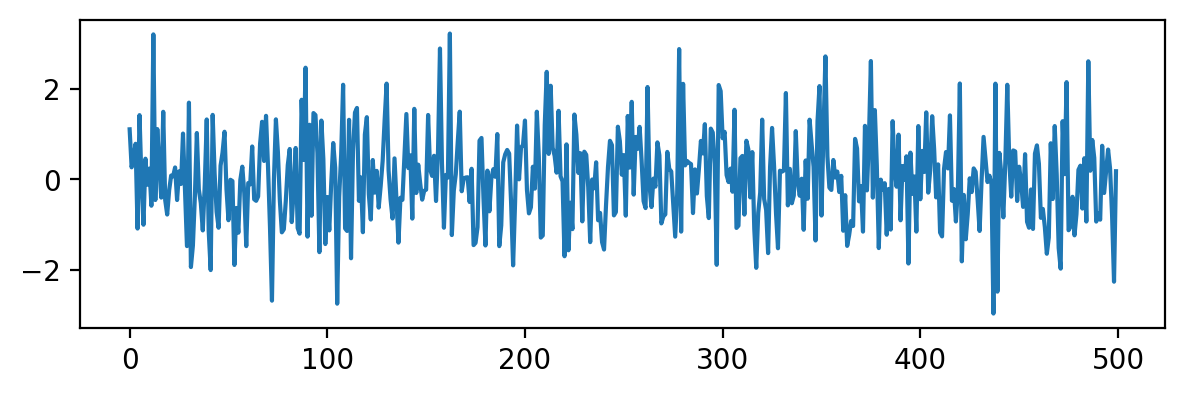

In [ ]:
sr, sec = 22050, 2
y = np.random.randn(sr * sec)
plt.plot(y[:500])
Audio(y, rate=sr)

In [ ]:
zcr(y)

0.4997392231116352

めっちゃ高い。これを使えばどこにノイズが入っているかがわかりそう

<br>

#### スペクトル重心

周波数の加重平均をとって音の重心がどこにあるかを調べる

librosaで各フレームのスペクトル重心を調べる  
[librosa.feature.spectral_centroid —librosa0.9.1ドキュメント](http://librosa.org/doc/main/generated/librosa.feature.spectral_centroid.html)

<br>

例えば100hzと300hzが1:1で混ざった音だと

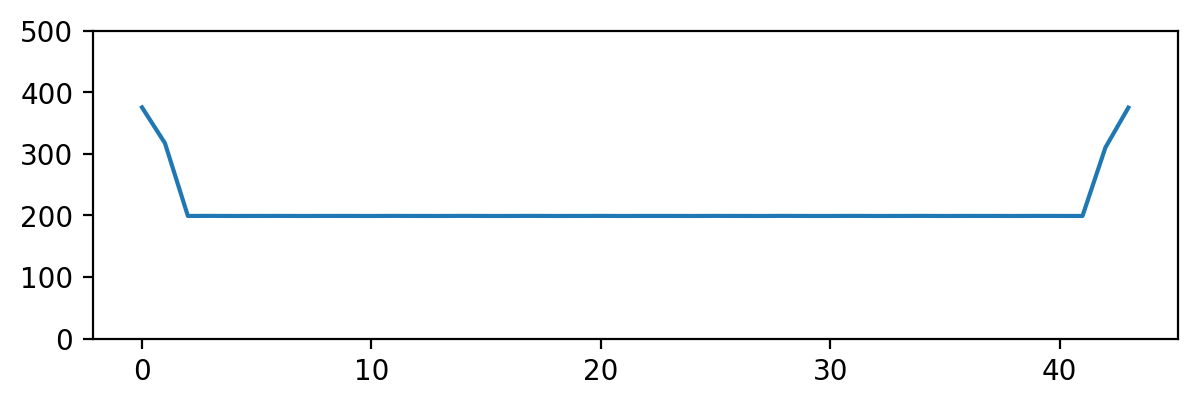

In [ ]:
y = sin_wave(100, sr=sr) + sin_wave(300, sr=sr)
sc, = librosa.feature.spectral_centroid(y, sr=sr)
plt.plot(sc)
plt.ylim(0, 500);

$ \frac{1 \times 100 \, + \, 1 \times 300}{1 + 1} = 200$ になるし(両端は知らん)

1:3で混ぜると

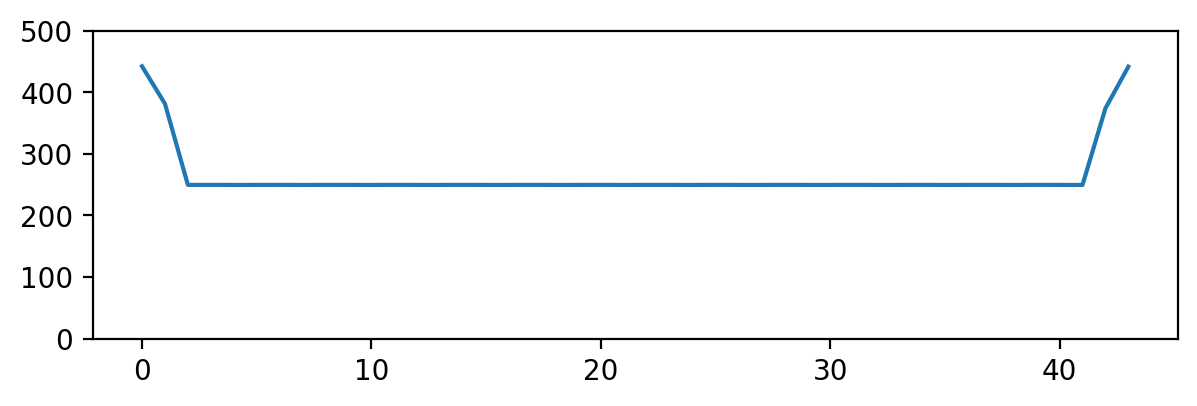

In [ ]:
y = 1 * sin_wave(100, sr=sr) + 3 * sin_wave(300, sr=sr)
sc, = librosa.feature.spectral_centroid(y, sr=sr)
plt.plot(sc)
plt.ylim(0, 500);

$ \frac{1 \times 100 \, + \, 3 \times 300}{1 + 3} = 250$ になる

メロディラインとれそうって思ってやってみたけどそんな都合よくはいかなかった

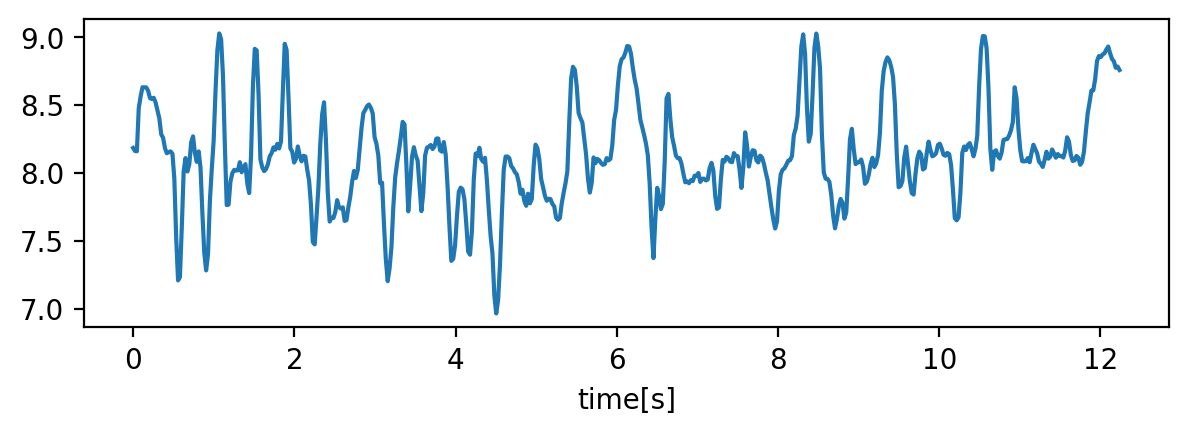

In [ ]:
display(Audio(vocal, rate=sr))
sc, = librosa.feature.spectral_centroid(vocal, sr=sr)
plt.plot(np.arange(len(sc)) * 512 / sr, np.log(sc))
plt.xlabel('time[s]');

<br>

#### スペクトルロールオフ

スペクトルの85%を占める周波数(?)  
この範囲ではこの周波数以下の周波数が85%を占めているよ！というのが分かる

<br>

librosaで各フレームの以下略  
[librosa.feature.spectral_rolloff —librosa0.9.1ドキュメント](https://librosa.org/doc/main/generated/librosa.feature.spectral_rolloff.html)

<br>

例えば 100hz, 200hz, 300hz, ... , 1000hz の音を足した音だと

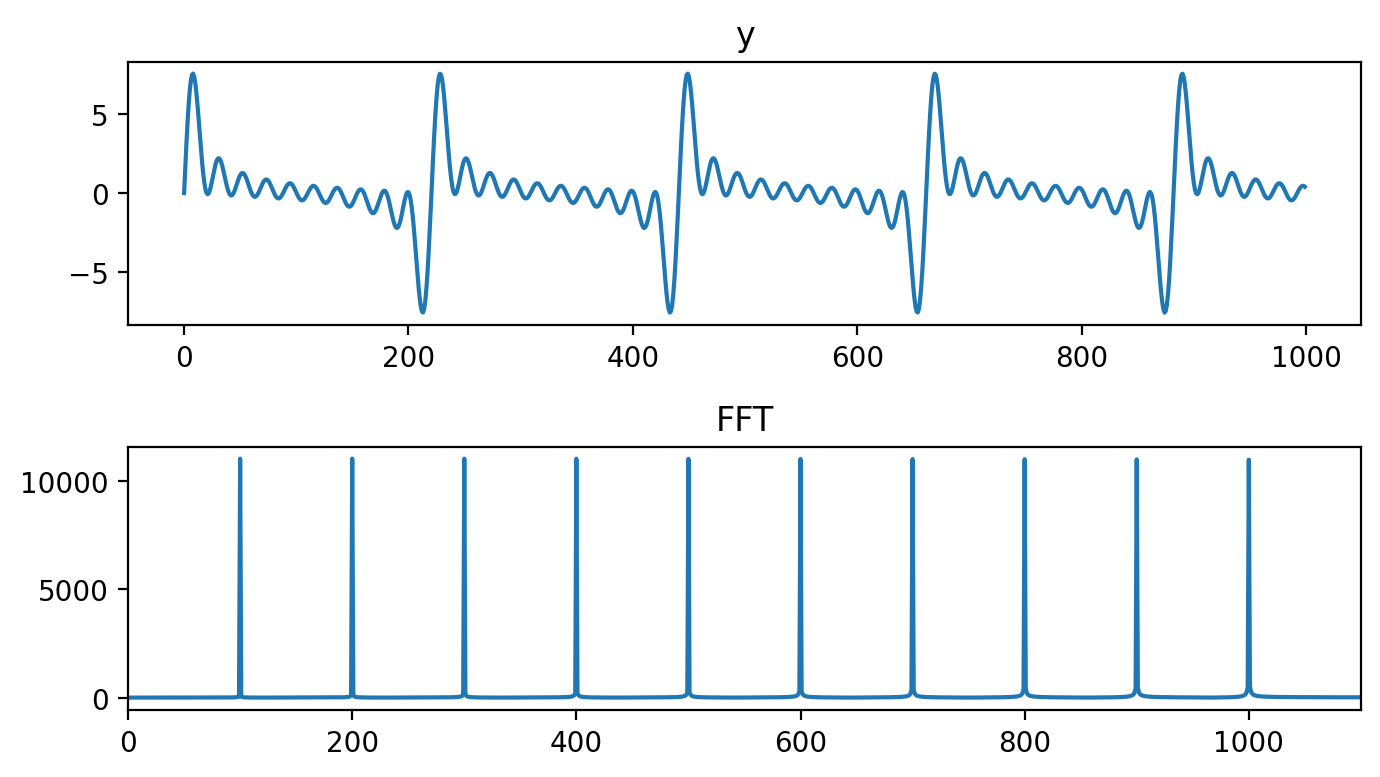

In [ ]:
sr, sec = 22050, 1
n = sr * sec
y = np.zeros(n)
for i in range(1, 11):
    y += sin_wave(i * 100, sr, sec)
c = np.abs(np.fft.fft(y))[:n // 2]
x = np.fft.fftfreq(n, d=1/sr)[:n // 2]
plt.figure(figsize=(7, 4))
plt.subplot(211)
plt.title('y')
plt.plot(y[:1000])
plt.subplot(212)
plt.title('FFT')
plt.plot(x, c)
plt.xlim(0, 1100)
plt.tight_layout();

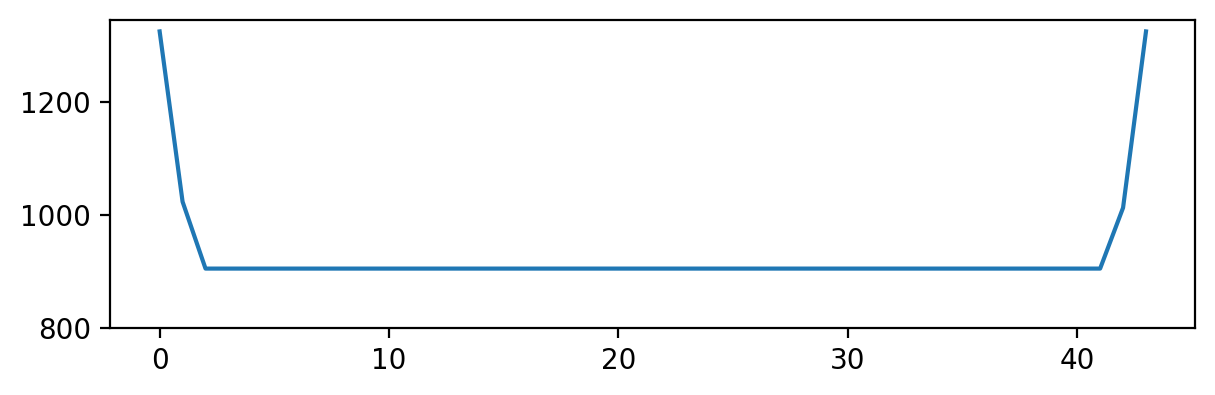

In [ ]:
rolloff, = librosa.feature.spectral_rolloff(y, sr=sr)
plt.plot(rolloff)
plt.ylim(800,);

900になる

ボーカル音源でやるとこうなる

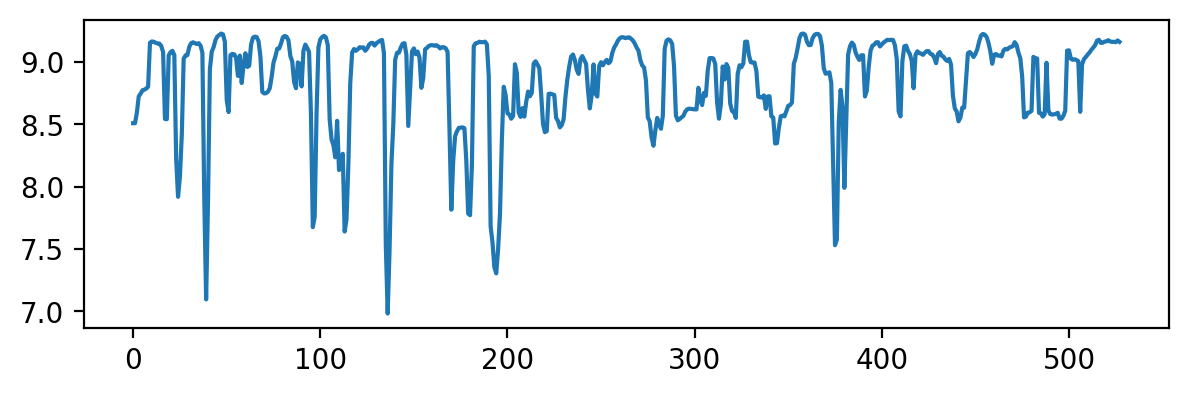

In [ ]:
rolloff, = librosa.feature.spectral_rolloff(vocal, sr=sr)
plt.plot(np.log(rolloff));

これもちょっとボーカルとるのは難しそう？

<br>

#### 定Q変換 (CQT)

STFTを対数表記にして音楽的な音高を分かりやすくしたもの

音楽では、音が半音上がると周波数は $2^{\frac{1}{12}}$ 倍される。つまり指数関数的に増加する  
それぞれの音の周波数をグラフにするとこうなる

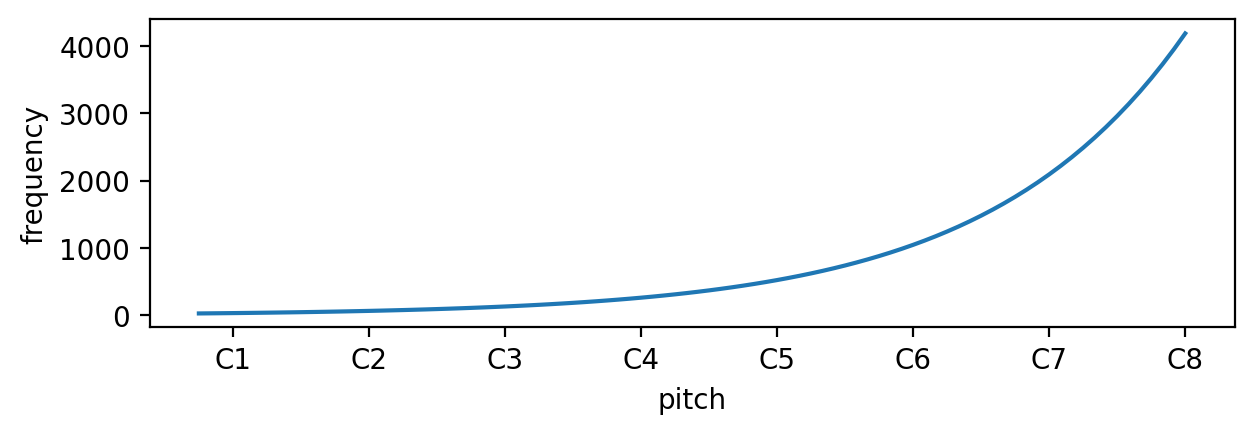

In [ ]:
A4 = 440. # 基準音の周波数
freq = [A4 * 2 ** ((n - 48)/12) for n in range(88)]
plt.plot(freq);
plt.xticks(range(3, 88, 12), [f'C{i}' for i in range(1, 9)])
plt.xlabel('pitch')
plt.ylabel('frequency');

縦軸を対数にすると線形になる

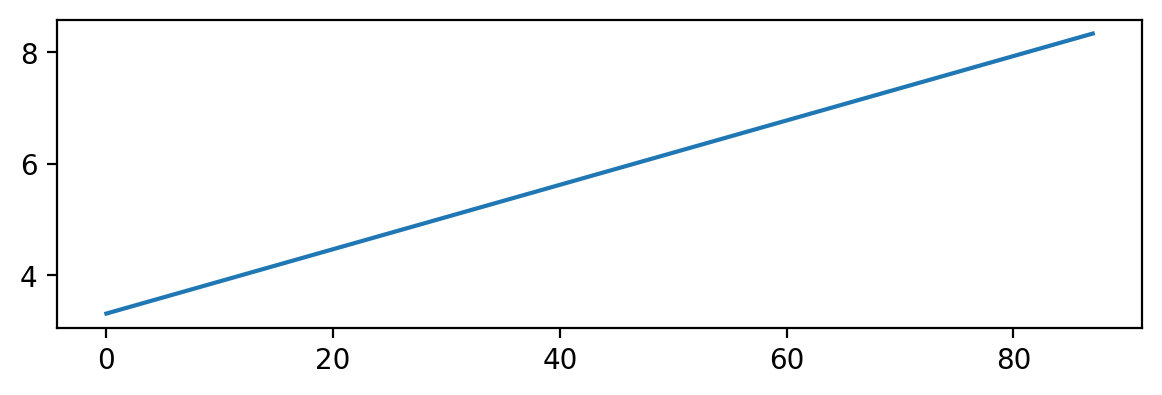

In [ ]:
plt.plot(np.log(freq));

定Q変換では、STFTの結果を対数で表し、半音ごとにまとめる  
こうすることで音楽的な音高の推移が分かりやすくなる

<br>

librosaを用いて各フレームで定Q変換を行った結果を取得できる  
[librosa.cqt —librosa0.9.1ドキュメント](https://librosa.org/doc/0.9.1/generated/librosa.cqt.html#librosa.cqt)

In [ ]:
y = np.array([])
sr = 22050
for i in (0, 2, 4, 5, 7, 9, 11, 12):
    y = np.append(y, sin_wave(note2freq(60 + i), sr=sr, sec=0.2))
Audio(y, rate=sr)

In [ ]:
plt.rcParams['figure.figsize'] = (7, 4)

/home/komiya/private/study/sound-processing/.venv/lib/python3.9/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


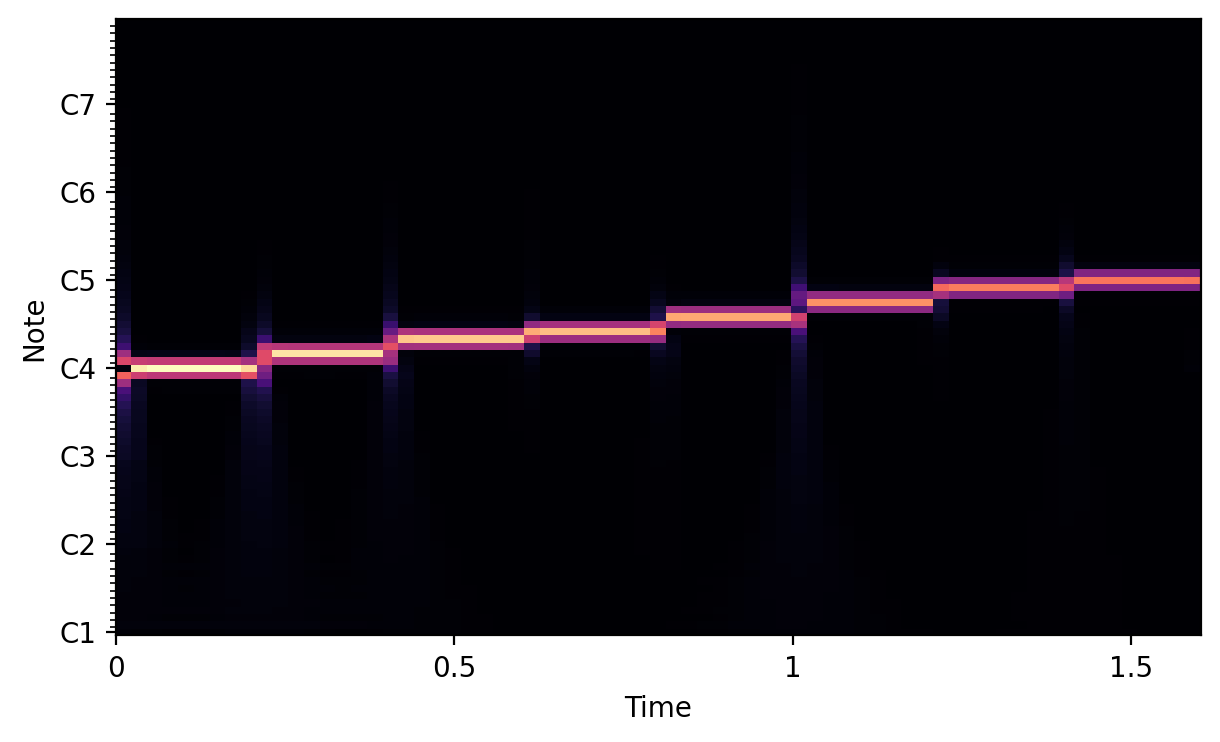

In [ ]:
cqt = np.abs(librosa.cqt(y))
librosa.display.specshow(cqt, x_axis='time', y_axis='cqt_note');

メロディラインをとりたければSTFTよりこっちのほうがいいかも

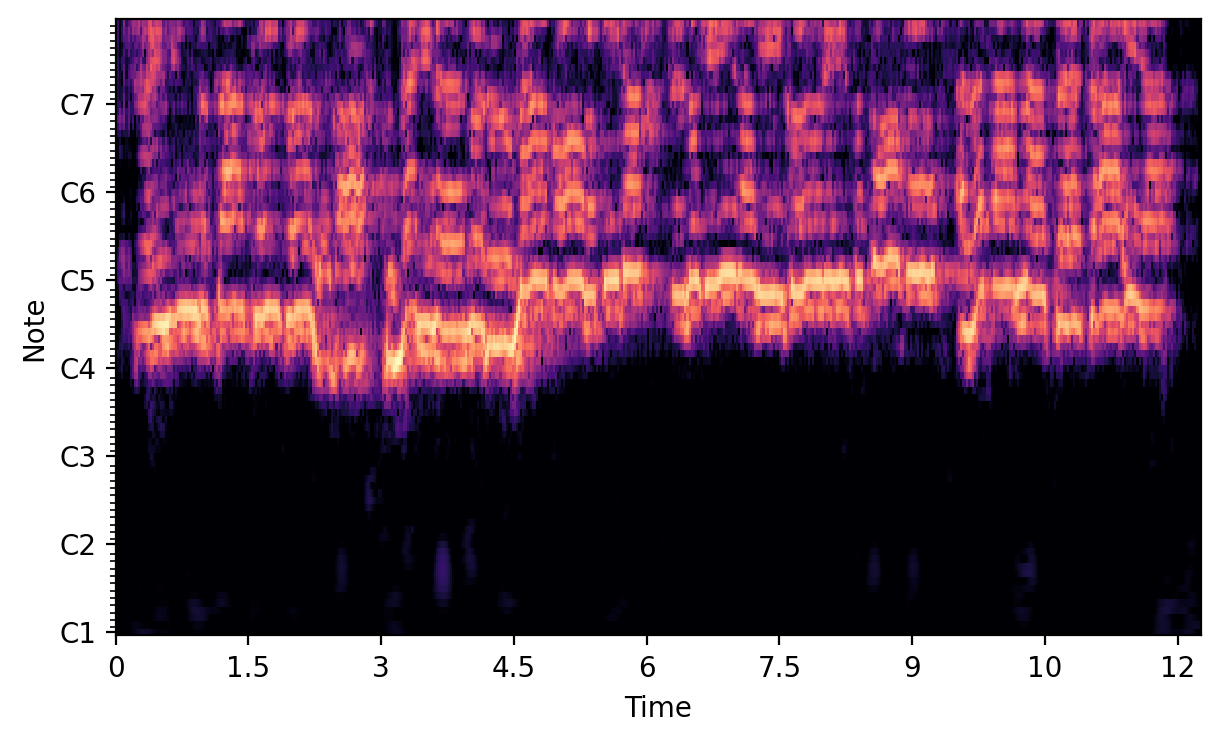

In [ ]:
display(Audio(vocal, rate=sr))
cqt = np.abs(librosa.cqt(vocal))
librosa.display.specshow(
    librosa.amplitude_to_db(cqt), x_axis='time', y_axis='cqt_note');

<br>

#### クロマ周波数

定Q変換をピッチクラスごとにまとめたもの。  
C1, C2, C3, ... はすべて**C**(ド)、A1, A2, A3, ... はすべて**A**(ラ)のようにまとめる  
オクターブを無視するということ

librosaで以下略  
[librosa.feature.chroma_cqt —librosa0.9.1ドキュメント](https://librosa.org/doc/0.9.1/generated/librosa.feature.chroma_cqt.html#librosa.feature.chroma_cqt)

/home/komiya/private/study/sound-processing/.venv/lib/python3.9/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=552
  warnings.warn(


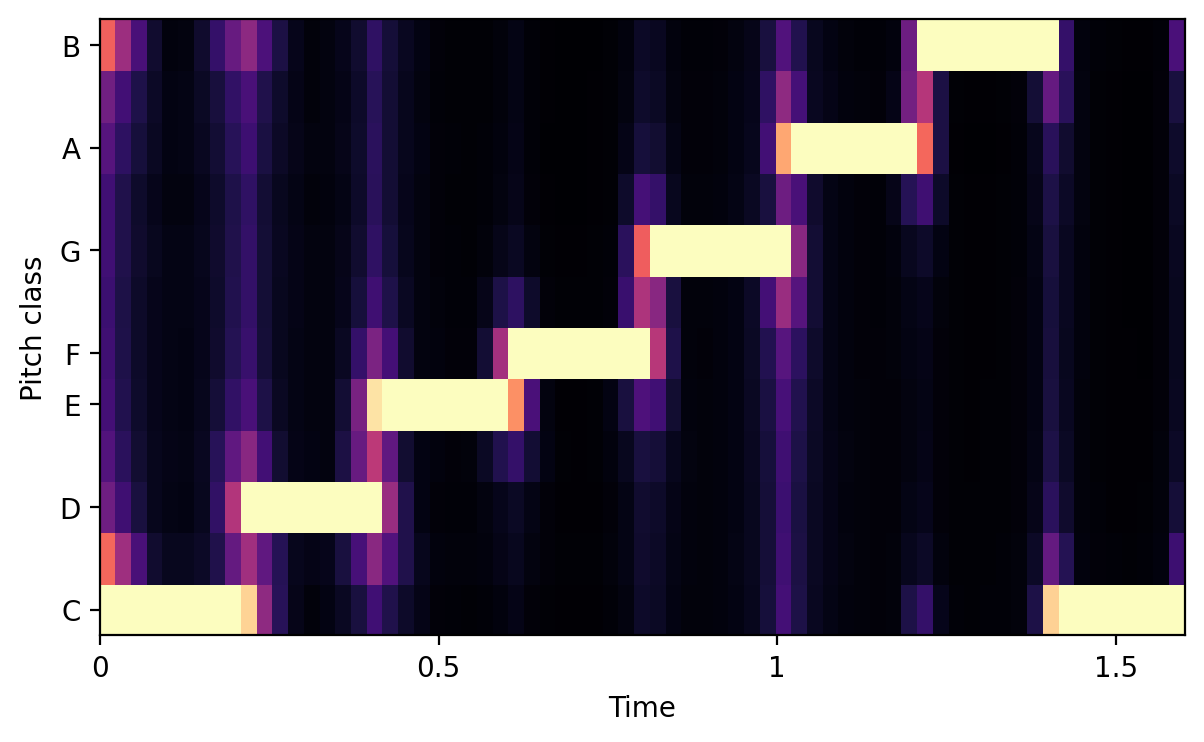

In [ ]:
chroma = librosa.feature.chroma_cqt(y)
librosa.display.specshow(chroma, x_axis='time', y_axis='chroma');

コード進行をとることができそう

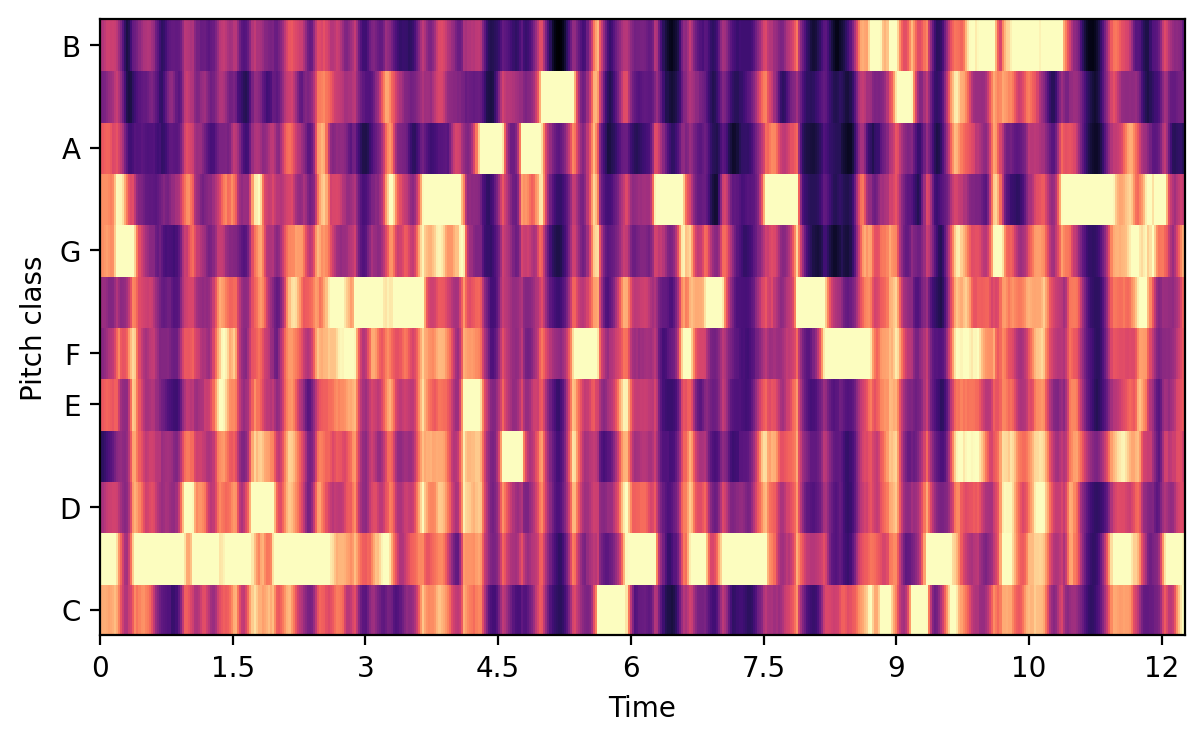

In [ ]:
acc, sr = librosa.load('sample-sounds/shiningstar-sep/accompaniment.wav')
display(Audio(acc, rate=sr))
chroma = librosa.feature.chroma_cqt(acc)
librosa.display.specshow(chroma, x_axis='time', y_axis='chroma');

ちょっとわかりづらい

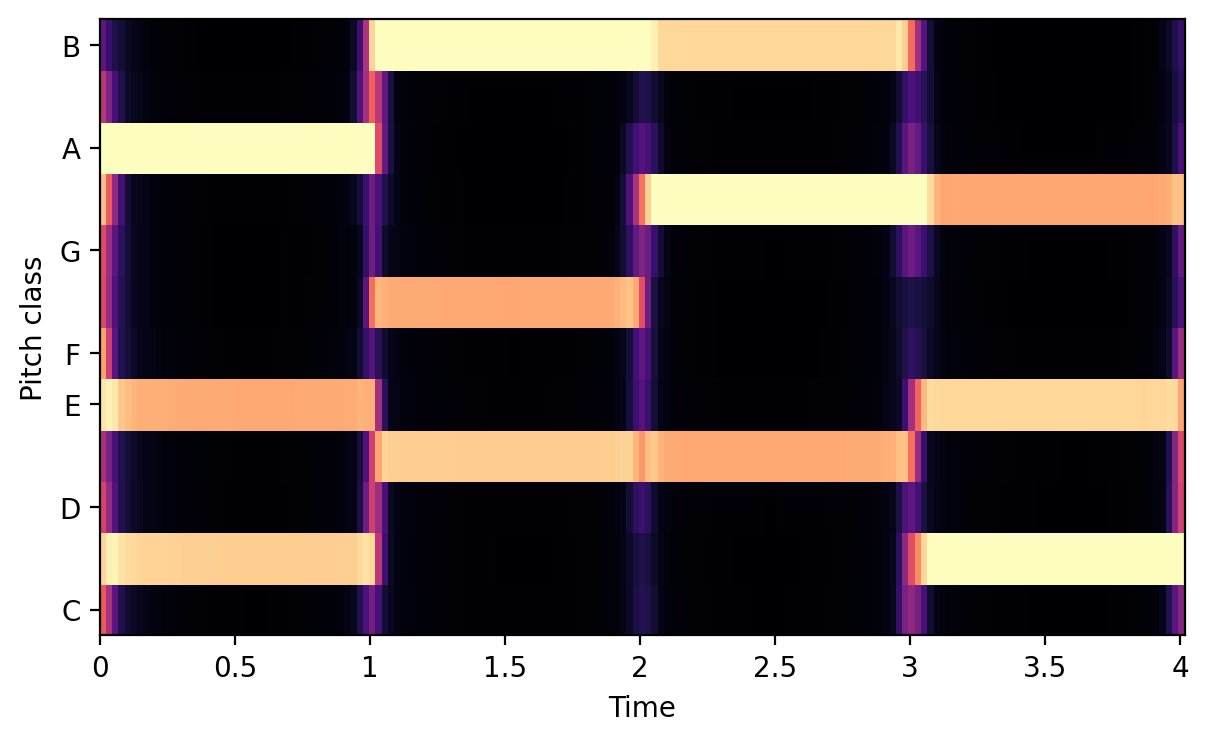

In [ ]:
y = np.array([])
sr, sec = 22050, 1
for chord in ((0, 4, 7), (2, 6, 9), (-1, 2, 6), (4, 7, 11)):
    y_chord = np.zeros(sr*sec)
    for note in chord:
        y_chord += sin_wave(note2freq(57 + note), sr=sr)
    y = np.append(y, y_chord)
display(Audio(y, rate=sr))
chroma = librosa.feature.chroma_cqt(y)
librosa.display.specshow(chroma, x_axis='time', y_axis='chroma');

これぐらいはっきりしてたら分かるね